# Multi scale matching pipeline

## Preparation

### Imports

In [10]:
# Processing
import cv2
import numpy as np
import pywt
import skimage
import SimpleITK as sitk

# Data handling
import tifffile
import os

# Data visualization
import matplotlib.pyplot as plt

### Load images

In [11]:
sample_dir = '../data/Samples_LoD_3/1M01.mrxs/'

images = []
masks = []

i = 0
while os.path.exists(sample_dir + str(i) + '.tiff') and os.path.exists(sample_dir + str(i) + '_mask.tiff'):
    images.append(tifffile.imread(sample_dir + str(i) + '.tiff').astype(np.uint8))
    print(f'Loaded 1M01.mrxs/{i}.tiff')
    masks.append(tifffile.imread(sample_dir + str(i) + '_mask.tiff').astype(np.bool))
    print(f'Loaded 1M01.mrxs/{i}_mask.tiff')
    i += 1

Loaded 1M01.mrxs/0.tiff
Loaded 1M01.mrxs/0_mask.tiff
Loaded 1M01.mrxs/1.tiff
Loaded 1M01.mrxs/1_mask.tiff
Loaded 1M01.mrxs/2.tiff
Loaded 1M01.mrxs/2_mask.tiff


### Parameters

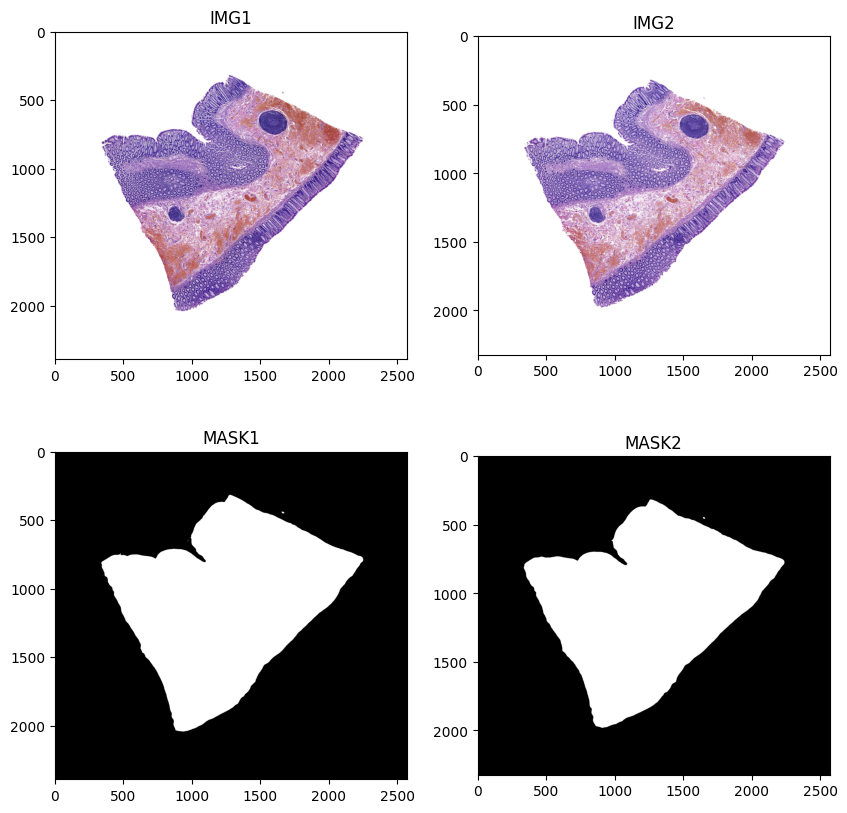

In [12]:
id_1 = 0
id_2 = 1

img1 = images[id_1]
img2 = images[id_2]
mask1 = masks[id_1]
mask2 = masks[id_2]

_, axes = plt.subplots(2,2, figsize=(10, 10))
axes[0,0].imshow(img1)
axes[0,1].imshow(img2)
axes[1,0].imshow(mask1, cmap='gray')
axes[1,1].imshow(mask2, cmap='gray')
axes[0,0].set_title('IMG1')
axes[0,1].set_title('IMG2')
axes[1,0].set_title('MASK1')
axes[1,1].set_title('MASK2')
plt.show() 

### H&D deconvolution

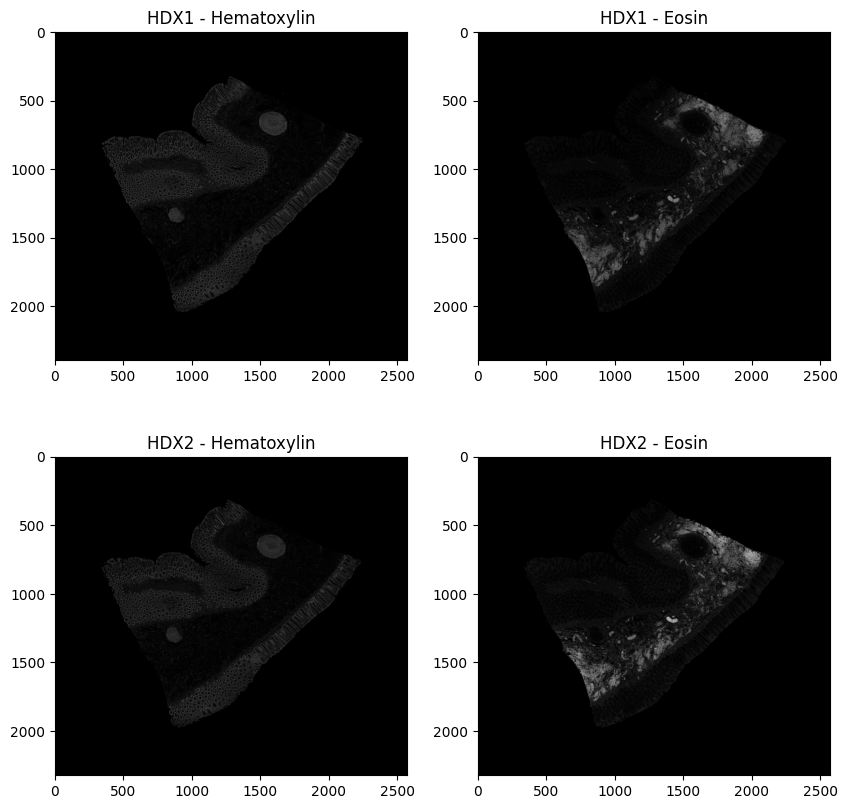

In [13]:
def hdx_split(img: np.ndarray):
    stain_matrix = skimage.color.hdx_from_rgb
    deconvoluted = skimage.color.separate_stains(img, stain_matrix)
    
    return deconvoluted[...,:-1]

hdx1 = hdx_split(img1)
hdx2 = hdx_split(img2)

hem1 = hdx1[:,:,0]
hem2 = hdx2[:,:,0]
eos1 = hdx1[:,:,1]
eos2 = hdx2[:,:,1]

_, axes = plt.subplots(2,2, figsize=(10, 10))
axes[0,0].imshow(hem1, cmap='gray')
axes[0,1].imshow(eos1, cmap='gray')
axes[1,0].imshow(hem2, cmap='gray')
axes[1,1].imshow(eos2, cmap='gray')
axes[0,0].set_title('HDX1 - Hematoxylin')
axes[0,1].set_title('HDX1 - Eosin')
axes[1,0].set_title('HDX2 - Hematoxylin')
axes[1,1].set_title('HDX2 - Eosin')
plt.show()

## Adaptive pyramid using bior6.8 wavlet transform 

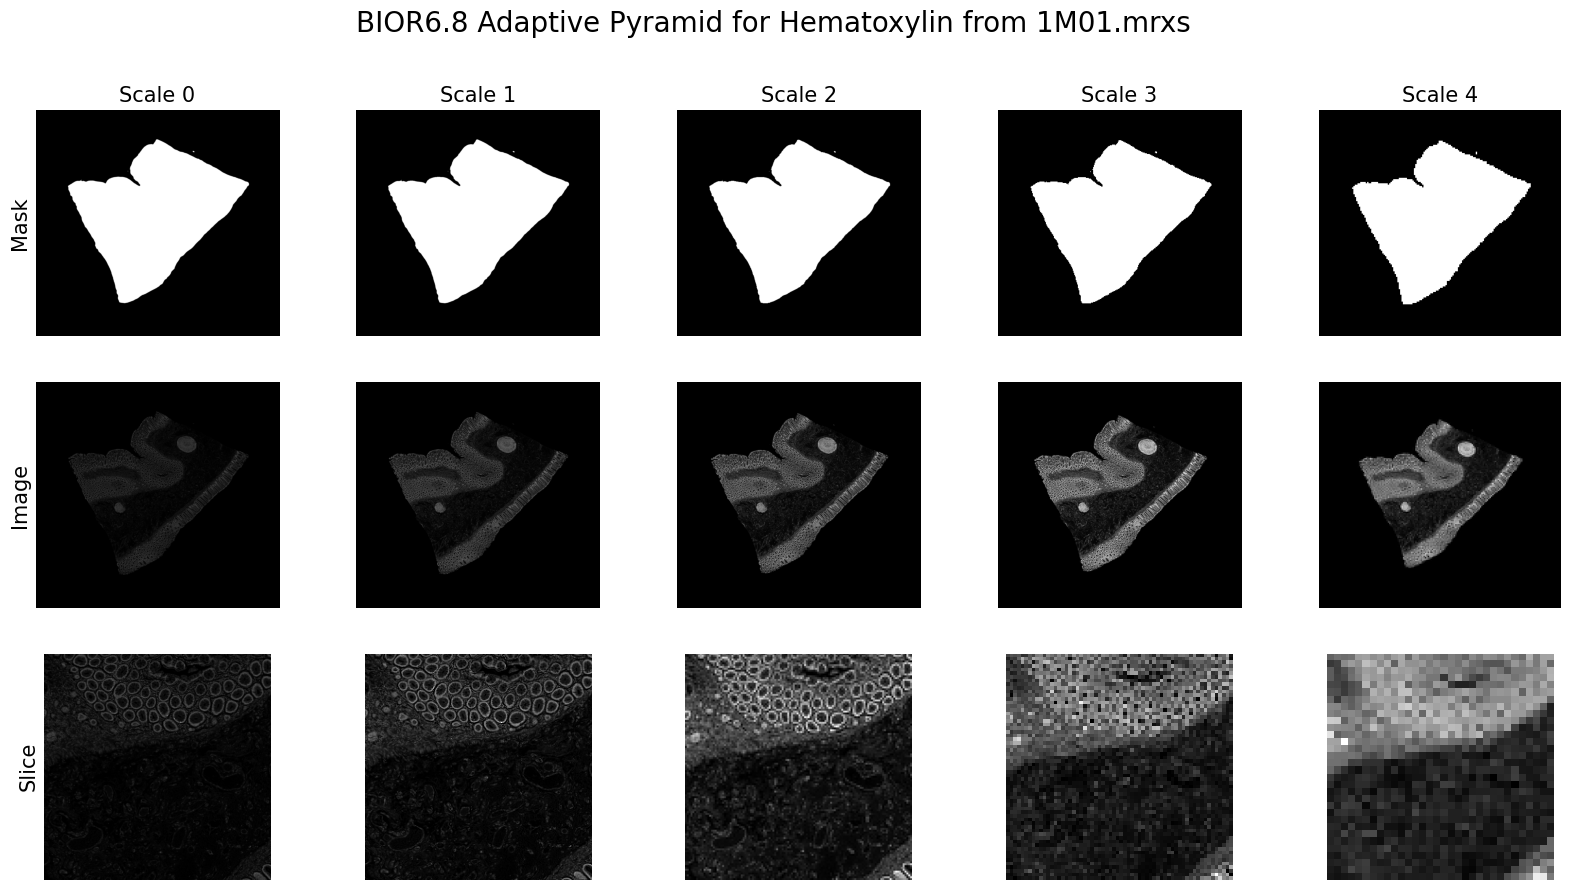

In [14]:
def adaptive_pyramid(image: np.ndarray, mask: np.ndarray, levels: int = 4):
    imgs  = [image]
    masks = [mask.astype(bool)]
    cur_i = image
    cur_m = mask.astype(bool)
    
    for _ in range(levels-1):
        cA, _ = pywt.dwt2(cur_i, 'bior6.8')
        new_m_uint8 = cv2.resize(
            cur_m.astype(np.uint8),
            (cA.shape[1], cA.shape[0]),
            interpolation=cv2.INTER_NEAREST
        )
        new_m = new_m_uint8.astype(bool)

        # Normalize the coefficients to [0, 1]
        cA = (cA - cA.min()) / (cA.max() - cA.min() + 1e-12)
        cA = cA - np.median(cA[~new_m])
        cA = np.clip(cA, 0, 1)
        
        imgs.append(cA)
        masks.append(new_m)
        
        cur_i = cA
        cur_m = new_m

    return imgs, masks

def relative_slice(img: np.ndarray, patch_scale: float = 0.2, patch_width: int = 0.5, patch_height: int = 0.5):
    h, w, = img.shape[:2]
    
    cy, cx = int(h * patch_height), int(w * patch_width)
    patch_size = int(patch_scale * min(h, w) // 2)
    
    slice_img  = img[cy-patch_size:cy+patch_size, cx-patch_size:cx+patch_size]

    return slice_img

def hide_ticks(axes):    
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

def grid_plot(images: list[list],
              x_labels: list[str] | None = None,
              y_labels: list[str] | None = None,
              title: str = '',
              figsize: tuple[float,float] = (20, 10),
              cmaps: str | list | None = None):
    n_rows, n_cols = len(images), len(images[0])
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
    fig.suptitle(title, fontsize=20, y=0.98)

    if not isinstance(cmaps, list):
        cmaps = [cmaps] * n_rows
        
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            ax.imshow(images[i][j], cmap=cmaps[i])

            if i == 0 and x_labels is not None:
                ax.set_title(x_labels[j], fontsize=15)

            if j == 0 and y_labels is not None:
                ax.set_ylabel(y_labels[i], fontsize=15)
                
    hide_ticks(axes)
    return fig, axes

bior_hem1, bior_mask1 = adaptive_pyramid(hem1, mask1, levels=5)
bior_hem2, bior_mask2 = adaptive_pyramid(hem2, mask2, levels=5)

bior_eos1, _ = adaptive_pyramid(eos1, mask1, levels=5)
bior_eos2, _ = adaptive_pyramid(eos2, mask2, levels=5)

slices = [relative_slice(bior_hem1[i]) for i in range(len(bior_hem1))]

_ = grid_plot(
    [bior_mask1, bior_hem1, slices],
    x_labels=[f'Scale {i}' for i in range(len(bior_hem1))],
    y_labels=['Mask', 'Image', 'Slice'],
    title='BIOR6.8 Adaptive Pyramid for Hematoxylin from 1M01.mrxs',
    cmaps='gray'
)

plt.show()

## Image enchancement

### CLAHE Histogram Equalization

Processing 0
Hematoxylin min/max: 0.0/0.8441729609537498
Eosin min/max: 0.0/0.2780730398101597
Processing 1
Hematoxylin min/max: 0.0/0.937425628611435
Eosin min/max: 0.0/0.9468322653540087
Processing 2
Hematoxylin min/max: 0.0/0.9169947280259363
Eosin min/max: 0.0/0.9437423230032038
Processing 3
Hematoxylin min/max: 0.0/0.9075966828096116
Eosin min/max: 0.0/0.9480447563404135
Processing 4
Hematoxylin min/max: 0.0/0.9344800976360053
Eosin min/max: 0.0/0.952442248065956


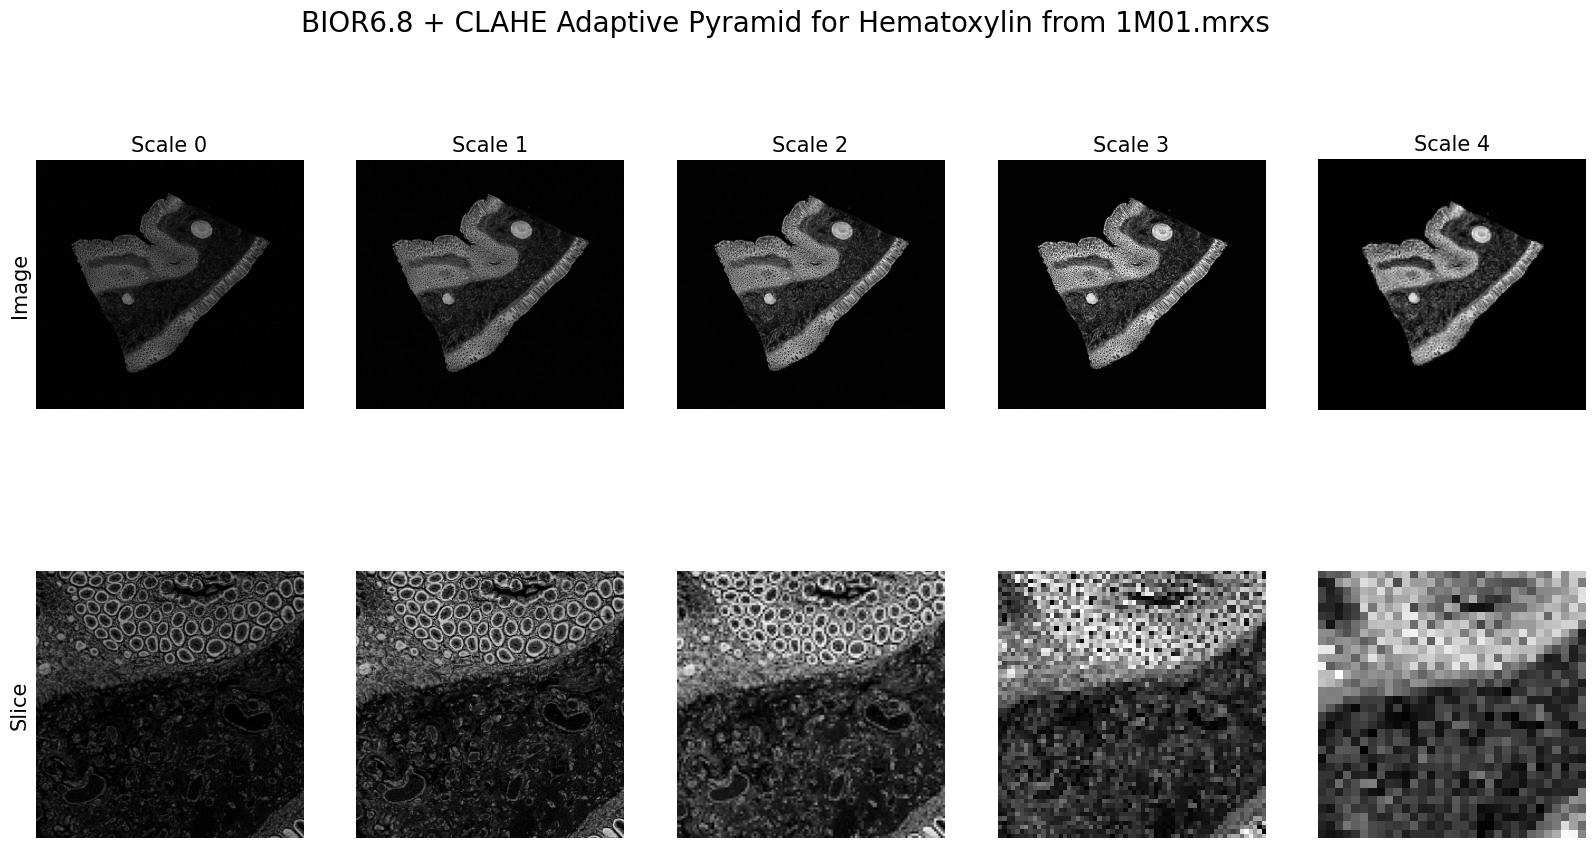

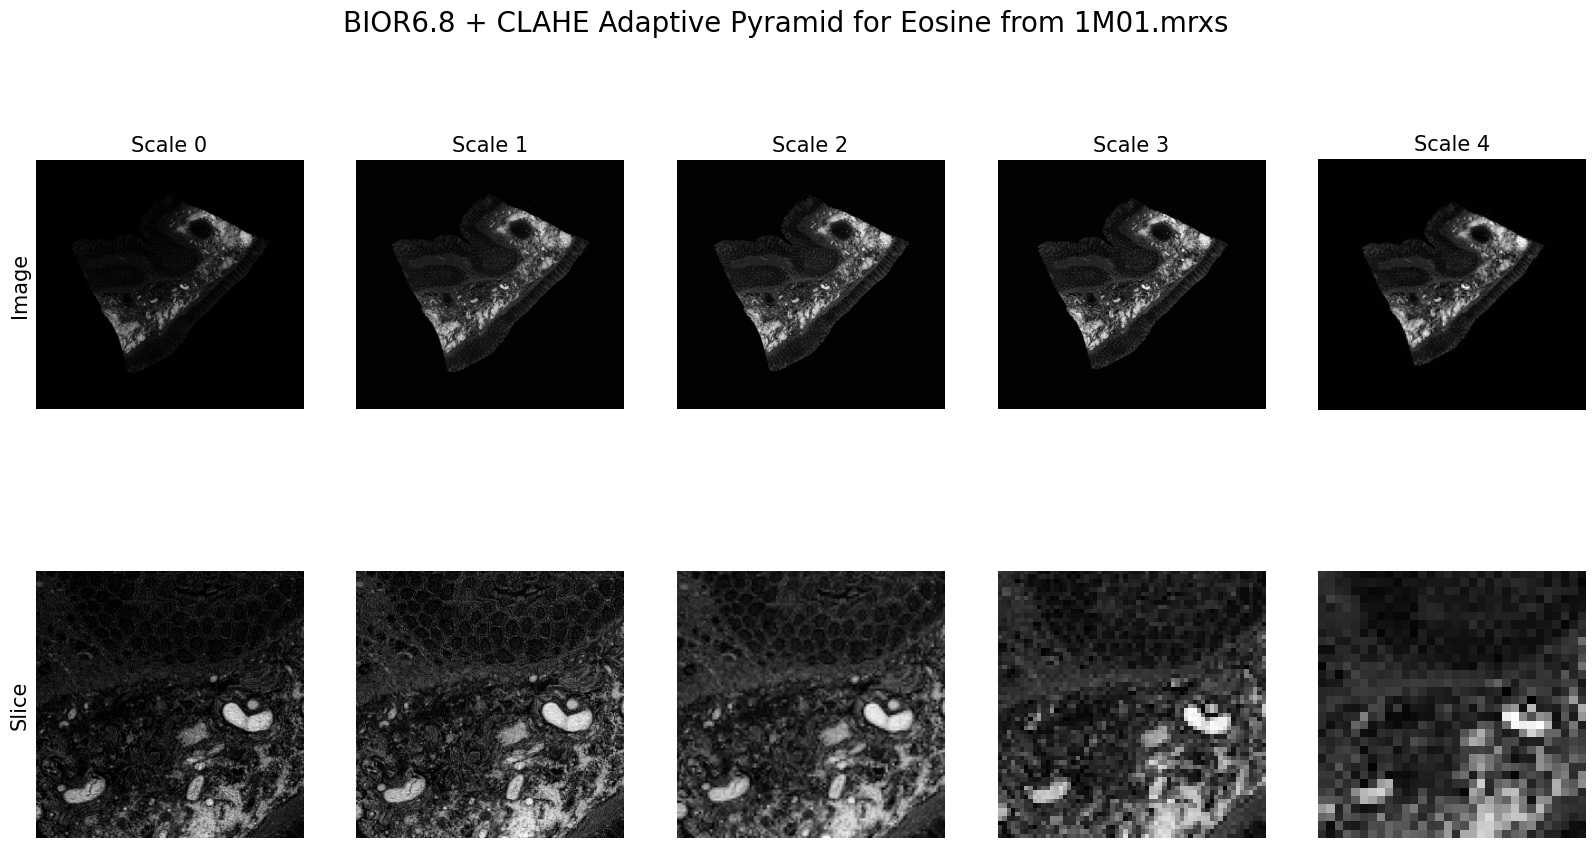

In [15]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))

for i in range(len(bior_hem1)):
    print(f'Processing {i}')
    print(f'Hematoxylin min/max: {bior_hem1[i].min()}/{bior_hem1[i].max()}')
    print(f'Eosin min/max: {bior_eos1[i].min()}/{bior_eos1[i].max()}')
    bior_hem1[i] = clahe.apply((bior_hem1[i] * 255).astype(np.uint8))
    bior_hem2[i] = clahe.apply((bior_hem2[i] * 255).astype(np.uint8))
    
    bior_eos1[i] = clahe.apply((bior_eos1[i] * 255).astype(np.uint8))
    bior_eos2[i] = clahe.apply((bior_eos2[i] * 255).astype(np.uint8))
    
slices_hem = [relative_slice(bior_hem1[i]) for i in range(len(bior_hem1))]
slices_eos = [relative_slice(bior_eos1[i]) for i in range(len(bior_eos1))]

_ = grid_plot(
    [bior_hem1, slices_hem],
    x_labels=[f'Scale {i}' for i in range(len(bior_hem1))],
    y_labels=['Image', 'Slice'],
    title='BIOR6.8 + CLAHE Adaptive Pyramid for Hematoxylin from 1M01.mrxs',
    cmaps='gray'
)
plt.show()

_ = grid_plot(
    [bior_eos1, slices_eos],
    x_labels=[f'Scale {i}' for i in range(len(bior_hem1))],
    y_labels=['Image', 'Slice'],
    title='BIOR6.8 + CLAHE Adaptive Pyramid for Eosine from 1M01.mrxs',
    cmaps='gray'
)
plt.show()

### Enchancing nuclei for hematoxylin

In [16]:
def enhance_nuclei(h_channel):
    denoised = cv2.fastNlMeansDenoising(
        h_channel, 
        h=9,
        templateWindowSize=7,
        searchWindowSize=21
    )
    frangi = skimage.filters.frangi(denoised, scale_range=(1, 3))
    frangi_scaled = (255 * (frangi - frangi.min()) / (frangi.max() - frangi.min())).astype(np.uint8)
    return cv2.addWeighted(denoised, 0.5, frangi, 0.5, 0)

#for i in range(len(bior_hem1)):
#    print(f'Processing {i}')
#    bior_hem1[i] = enhance_nuclei(bior_hem1[i])
#    bior_hem2[i] = enhance_nuclei(bior_hem2[i])
#
#slices_hem = [relative_slice(bior_hem1[i]) for i in range(len(bior_hem1))]
#
#_ = grid_plot(
#    [bior_hem1, slices_hem],
#    x_labels=[f'Scale {i}' for i in range(len(bior_hem1))],
#    y_labels=['Image', 'Slice'],
#    title='Nuclei Enhancement for Hematoxylin from 1M01.mrxs',
#    cmaps='gray'
#)

## KAZE Keypoint detection

### KAZE Keypoint visualisation on bior6.8 pyramid

Processing images of size (2391, 2571) and (2324, 2571)
Found 9734 and 8094 keypoints
Processing images of size (1204, 1294) and (1170, 1294)
Found 3133 and 3209 keypoints
Processing images of size (610, 655) and (593, 655)
Found 680 and 572 keypoints
Processing images of size (313, 336) and (305, 336)
Found 263 and 225 keypoints
Processing images of size (165, 176) and (161, 176)
Found 101 and 101 keypoints


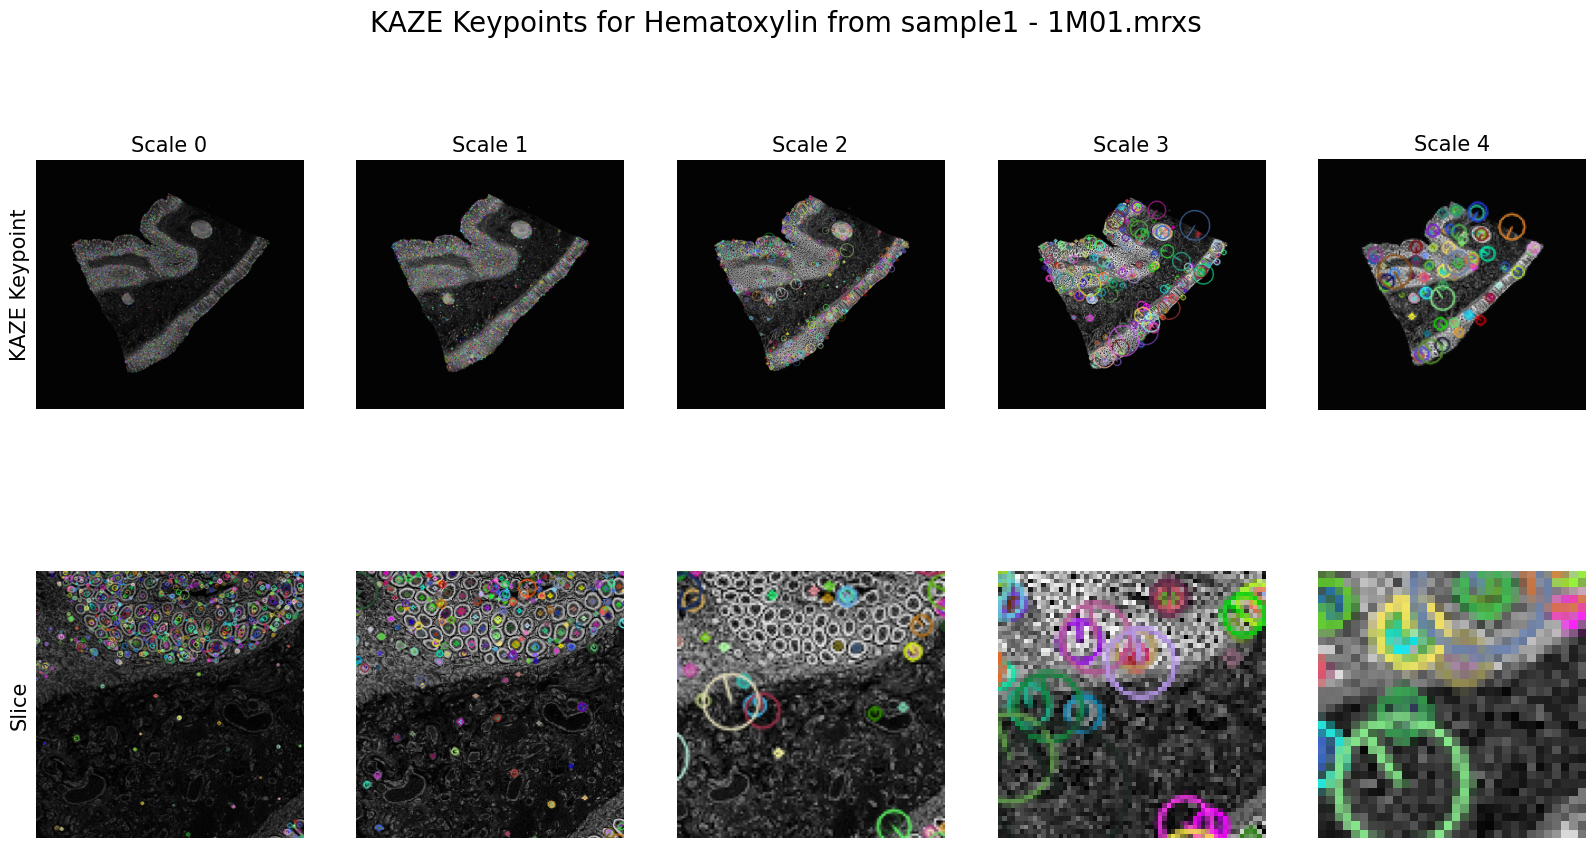

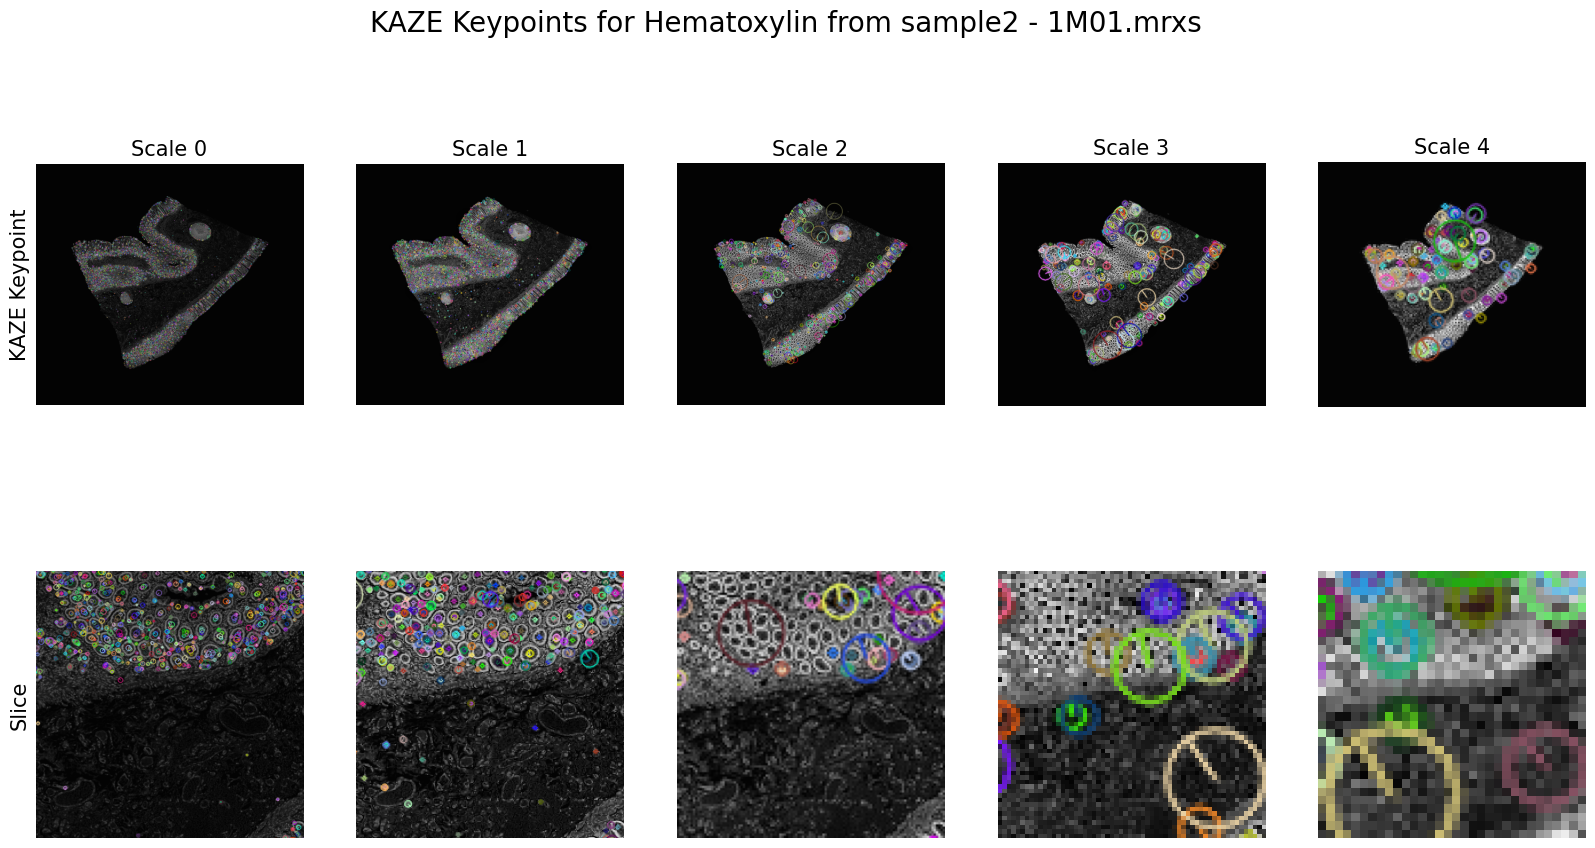

In [17]:
def erode_mask(mask: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.erode(mask.astype(np.uint8), kernel, iterations=1).astype(bool)

kaze = cv2.KAZE_create(upright=False,
    threshold=0.001, 
    nOctaves=4, 
    nOctaveLayers=4,
    diffusivity=cv2.KAZE_DIFF_PM_G2
)

kaze_vis1 = []
kaze_vis2 = []

for ihem1, ihem2, imask1, imask2 in zip(bior_hem1, bior_hem2, bior_mask1, bior_mask2):
    print(f'Processing images of size {ihem1.shape} and {ihem2.shape}')
    kp1, des1 = kaze.detectAndCompute(ihem1, erode_mask(imask1, kernel_size=3).astype(np.uint8))
    kp2, des2 = kaze.detectAndCompute(ihem2, erode_mask(imask2, kernel_size=3).astype(np.uint8))
    print(f'Found {len(kp1)} and {len(kp2)} keypoints')
    
    vis1 = cv2.drawKeypoints(ihem1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    vis2 = cv2.drawKeypoints(ihem2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    kaze_vis1.append(vis1)
    kaze_vis2.append(vis2)

slices1 = [relative_slice(kaze_vis1[i]) for i in range(len(kaze_vis1))]
slices2 = [relative_slice(kaze_vis2[i]) for i in range(len(kaze_vis2))]

_ = grid_plot(
    [kaze_vis1, slices1],
    x_labels=[f'Scale {i}' for i in range(len(bior_hem1))],
    y_labels=['KAZE Keypoint', 'Slice'],
    title='KAZE Keypoints for Hematoxylin from sample1 - 1M01.mrxs',
)
plt.show()

_ = grid_plot(
    [kaze_vis2, slices2],
    x_labels=[f'Scale {i}' for i in range(len(bior_hem1))],
    y_labels=['KAZE Keypoint', 'Slice'],
    title='KAZE Keypoints for Hematoxylin from sample2 - 1M01.mrxs',
)
plt.show()

### Keypoints matching

Processing level 2
Found 645 matches
Matches after Lowe's test: 244
Matches after mutual filtering: 181
Processing level 3
Found 263 matches
Matches after Lowe's test: 148
Matches after mutual filtering: 123
Processing level 2
Found 704 matches
Matches after Lowe's test: 385
Matches after mutual filtering: 324
Processing level 3
Found 200 matches
Matches after Lowe's test: 138
Matches after mutual filtering: 124
Matches after RANSAC: 55


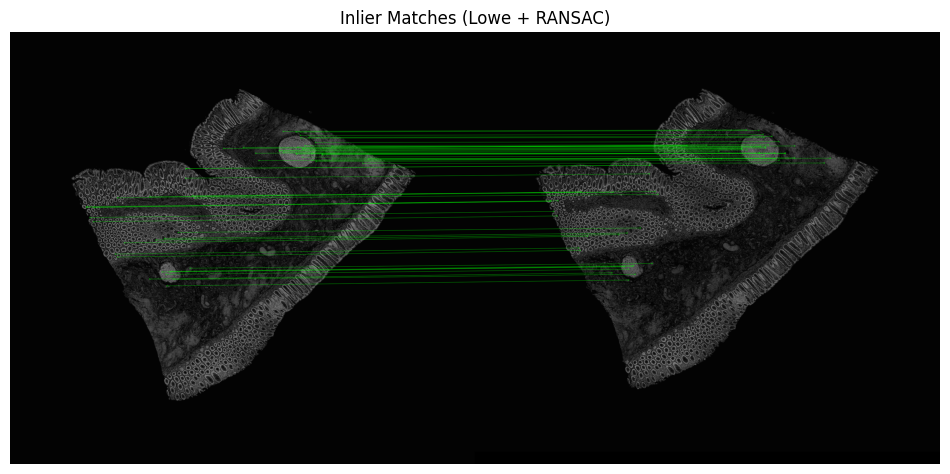

In [18]:
def lowes_test_ratio(matches: list[cv2.DMatch], ratio: float = 0.75) -> list[cv2.DMatch]:
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    return good_matches

def filter_mask(kp: list[cv2.KeyPoint], mask: np.ndarray) -> list[cv2.KeyPoint]:
    filtered_kp = []
    for k in kp:
        if mask[int(k.pt[1]), int(k.pt[0])]:
            filtered_kp.append(k)
    return filtered_kp

def scale_kp(kp: list[cv2.KeyPoint], scale: float) -> list[cv2.KeyPoint]:
    scaled_kp = []
    for k in kp:
        new_k = cv2.KeyPoint(k.pt[0] * scale, k.pt[1] * scale, k.size * scale, k.angle, k.response, k.octave, k.class_id)
        scaled_kp.append(new_k)
    return scaled_kp

def find_scaled(
        feature: cv2.Feature2D, 
        o_img1: np.ndarray, img1: np.ndarray, mask1: np.ndarray, 
        o_img2: np.ndarray, img2: np.ndarray, mask2: np.ndarray, 
        erosion_scale: int = 100
    ):
    
    erosion_s1 = (img1.shape[0] + img1.shape[1]) // erosion_scale
    erosion_s2 = (img2.shape[0] + img2.shape[1]) // erosion_scale
    mask1 = erode_mask(mask1, erosion_s1)
    mask2 = erode_mask(mask2, erosion_s2)
    
    kp1, des1 = kaze.detectAndCompute(img1, mask1.astype(np.uint8))
    kp2, des2 = kaze.detectAndCompute(img2, mask2.astype(np.uint8))
        
    img1_scale = o_img1.shape[0] / img1.shape[0]
    img2_scale = o_img2.shape[0] / img2.shape[0]
    
    kp1 = scale_kp(kp1, img1_scale)
    kp2 = scale_kp(kp2, img2_scale)
    
    return kp1, des1, kp2, des2
    
def merge_matches(match1: list[cv2.DMatch], match2: list[cv2.DMatch], q_offset: int, t_offset: int):
    assert q_offset >= 0 and t_offset >= 0

    adjusted_match2 = [
        cv2.DMatch(m.queryIdx + q_offset, m.trainIdx + t_offset, m.distance)
        for m in match2
    ]

    return match1 + adjusted_match2

def sample_matches(
        matches: list[cv2.DMatch], 
        kp1: list[cv2.KeyPoint], kp2: list[cv2.KeyPoint], 
        des1: list, des2: list,
        weights: np.ndarray[np.float32],
        sample_prc: float = 0.2,
        seed: int = 42
    ):

    assert len(weights) == len(matches)
    
    np.random.seed(seed)
    w_min = weights.min()
    w_max = weights.max()
    w_norm = ((weights - w_min) / (w_max - w_min))
    w_norm = w_norm / w_norm.sum()
    
    indexes = np.arange(len(weights))
    choice = np.random.choice(indexes, size=int(len(weights) * sample_prc), p=w_norm, replace=False)
    
    ret_kp1 = []
    ret_kp2 = []
    ret_des1 = []
    ret_des2 = []
    ret_matches = []
    for i, c in enumerate(choice):
        q_idx = matches[c].queryIdx
        t_idx = matches[c].trainIdx
        
        ret_matches.append(matches[c])
        ret_kp1.append(kp1[q_idx])
        ret_kp2.append(kp2[t_idx])
        ret_des1.append(des1[q_idx])
        ret_des2.append(des2[t_idx])
        ret_matches[i].queryIdx = i
        ret_matches[i].trainIdx = i

    return ret_matches, (ret_kp1, ret_des1), (ret_kp2, ret_des2)
    
def match_find_bior(
        feature: cv2.Feature2D, matcher: cv2.DescriptorMatcher,
        bior1_pyr: list[np.ndarray], bior2_pyr: list[np.ndarray],
        bior1_mask: list[np.ndarray], bior2_mask: list[np.ndarray],
        levels: list[int] = [0],
        erosion_scale: int = 100,
        mutual: bool = False,
        lowes_ratio: float = 0.75,
        weight_function: callable = None,
        sample_prc: float = 0.2,
        random_seed: int = 42
    ):
    
    weights = []
    ret_matches = []
    ret_kp1 = []
    ret_kp2 = []
    ret_des1 = []
    ret_des2 = []
    for l in levels:
        print(f'Processing level {l}')
        kp1, des1, kp2, des2 = find_scaled(
            feature, 
            bior1_pyr[0], bior1_pyr[l], bior1_mask[l], 
            bior2_pyr[0], bior2_pyr[l], bior2_mask[l], 
            erosion_scale=erosion_scale
        )
        
        matches = matcher.knnMatch(des1, des2, k=2)
        print(f'Found {len(matches)} matches')
        good_matches = lowes_test_ratio(matches, ratio=lowes_ratio)
        print(f"Matches after Lowe's test: {len(good_matches)}")
        
        if mutual:
            matches_rev = matcher.knnMatch(des2, des1, k=2)
            good_matches_rev = lowes_test_ratio(matches_rev, ratio=lowes_ratio)
            rev_pairs = set((m_rev.trainIdx, m_rev.queryIdx) for m_rev in good_matches_rev)
            good_matches = [m for m in good_matches if (m.queryIdx, m.trainIdx) in rev_pairs]
            print(f'Matches after mutual filtering: {len(good_matches)}')
        
        loc_weights = None
        if weight_function is not None:
            loc_weights = [weight_function(l, kp1[m.queryIdx].response) for m in good_matches]
            weights.extend(loc_weights)

        ret_matches = merge_matches(ret_matches, good_matches, len(ret_kp1), len(ret_kp2))
        ret_kp1.extend(kp1)
        ret_kp2.extend(kp2)
        ret_des1.extend(des1)
        ret_des2.extend(des2)

    if weight_function is not None:
        return sample_matches(ret_matches, ret_kp1, ret_kp2, ret_des1, ret_des2, np.array(weights), sample_prc, random_seed)

    return ret_matches, (ret_kp1, ret_des1), (ret_kp2, ret_des2)

kaze = cv2.KAZE_create(upright=False,
    threshold=0.001, 
    nOctaves=4, 
    nOctaveLayers=4,
    diffusivity=cv2.KAZE_DIFF_PM_G2
)
matcher = cv2.FlannBasedMatcher({'algorithm':1, 'trees':5} , {'checks':50})
levels = [2, 3]

w_function = lambda l, r: (l + 1) * r / 2

hem_good_matches, (hem_kp1, _), (hem_kp2, _) = match_find_bior(
    kaze, matcher,
    bior_hem1, bior_hem2,
    bior_mask1, bior_mask2, 
    levels=levels,
    erosion_scale=200,
    mutual=True,
    lowes_ratio=0.75,
    weight_function=w_function,
    sample_prc=0.5
)

eos_good_matches, (eos_kp1, _), (eos_kp2, _) = match_find_bior(
    kaze, matcher,
    bior_eos1, bior_eos2,
    bior_mask1, bior_mask2,
    levels=levels,
    erosion_scale=200,
    mutual=True,
    lowes_ratio=0.75,
    weight_function=w_function,
    sample_prc=0.5
)


kp1 = hem_kp1 + eos_kp1
kp2 = hem_kp2 + eos_kp2

good_matches = merge_matches(hem_good_matches, eos_good_matches, len(hem_kp1), len(hem_kp2))

src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

H, mask = cv2.estimateAffinePartial2D(
    src_pts, dst_pts,
    method=cv2.RANSAC, 
    ransacReprojThreshold=4.0,
    refineIters=10
)

inlier_matches = [m for i, m in enumerate(good_matches) if mask[i]]
print(f'Matches after RANSAC: {len(inlier_matches)}')

vis_img1 = np.maximum(bior_hem1[0], bior_eos1[0])
vis_img2 = np.maximum(bior_hem2[0], bior_eos2[0])

matched_img = cv2.drawMatches(
    vis_img1, kp1,
    vis_img2, kp2,
    inlier_matches,
    None,
    matchColor=(0, 255, 0),
    singlePointColor=None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title('Inlier Matches (Lowe + RANSAC)')
plt.axis('off')
plt.show()

### Matching visualization

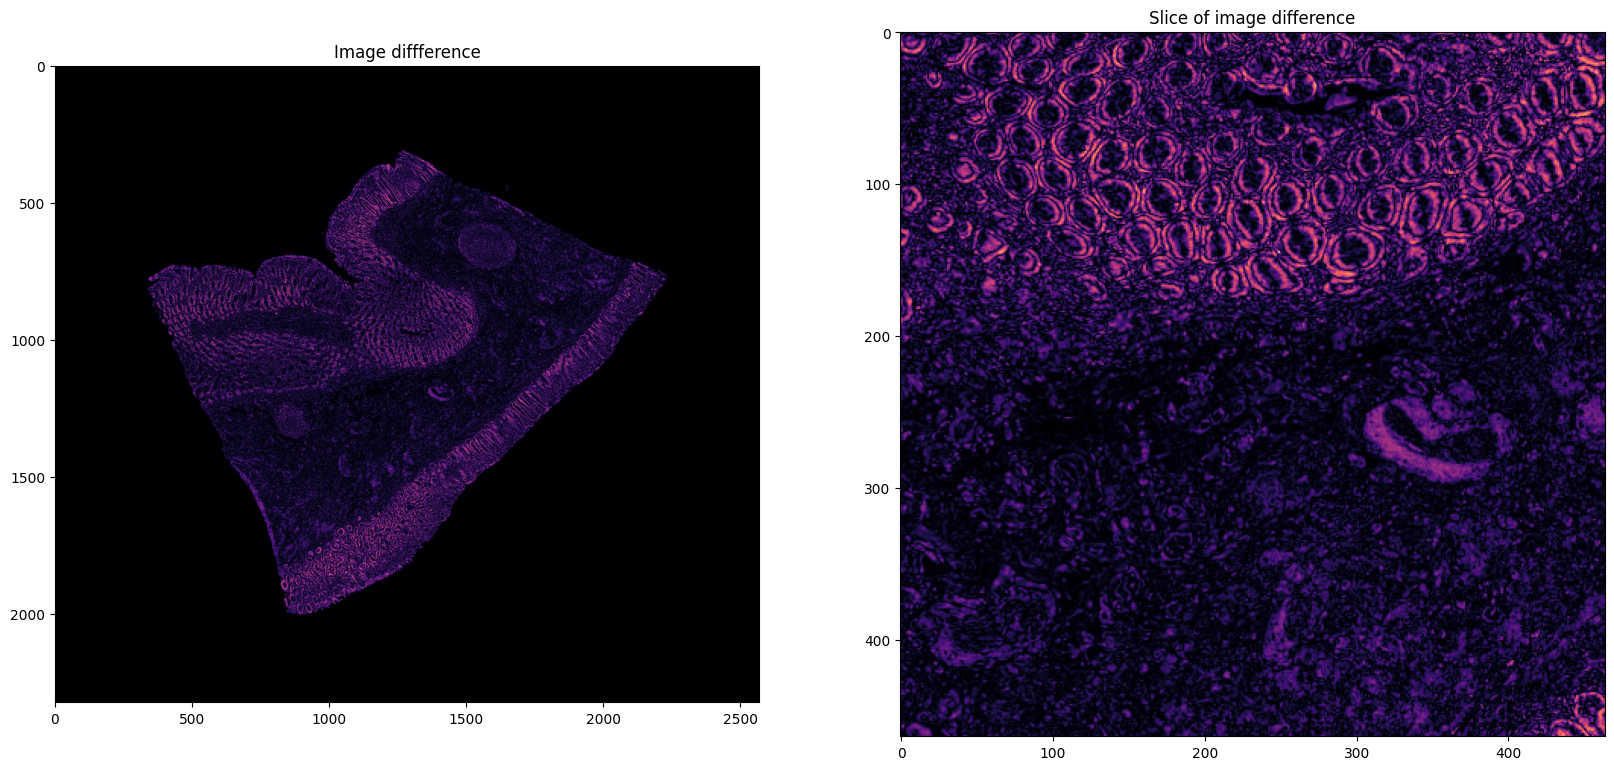

In [19]:
img1 = vis_img1
img2 = vis_img2

img1 = cv2.warpAffine(
    img1, H, (img2.shape[1], img2.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
)

diff = cv2.absdiff(img1, img2)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(diff, cmap='magma')
axes[0].set_title('Image diffference')
axes[1].imshow(relative_slice(diff), cmap='magma')
axes[1].set_title('Slice of image difference')
plt.show()

## Non-linear optimalization with B-spline 

### Adaptive pyramid transformation

In [20]:
for i in range(len(bior_hem1)):
    bior_hem1[i] = cv2.warpAffine(
        bior_hem1[i], H, (bior_hem2[i].shape[1], bior_hem2[i].shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    bior_eos1[i] = cv2.warpAffine(
        bior_eos1[i], H, (bior_eos2[i].shape[1], bior_eos2[i].shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    )
    bior_mask1[i] = cv2.warpAffine(
        bior_mask1[i].astype(np.uint8), H, (bior_mask2[i].shape[1], bior_mask2[i].shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE
    ).astype(bool)

### MMI

In [21]:
def sitk_mmi(
    img1: np.ndarray, img2: np.ndarray,
    mask1: np.ndarray = None, mask2: np.ndarray = None,
) -> tuple[sitk.Image, sitk.Transform]:

    img1 = sitk.GetImageFromArray(img1.astype(np.float32))
    img2 = sitk.GetImageFromArray(img2.astype(np.float32))

    img1.SetSpacing((1.0,) * img1.GetDimension())
    img2.SetSpacing((1.0,) * img2.GetDimension())
    img1.SetOrigin((0.0,) * img1.GetDimension())
    img2.SetOrigin((0.0,) * img2.GetDimension())

    # Erozja masek – zabezpieczenie przed krawędziami
    if mask1 is not None:
        kernel = np.ones((5, 5), np.uint8)
        mask1 = cv2.erode(mask1, kernel, iterations=1)
        mask2 = cv2.erode(mask2, kernel, iterations=1)
        mask1 = sitk.GetImageFromArray(mask1.astype(np.uint8))
        mask2 = sitk.GetImageFromArray(mask2.astype(np.uint8))

    reg = sitk.ImageRegistrationMethod()

    # Miara podobieństwa
    reg.SetMetricAsMattesMutualInformation(50)  # dokładniejsza
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.2)  # 20% pikseli

    reg.SetInterpolator(sitk.sitkLinear)

    if mask1 is not None:
        reg.SetMetricFixedMask(mask1)
    if mask2 is not None:
        reg.SetMetricMovingMask(mask2)

    reg.SetOptimizerAsLBFGSB(
        gradientConvergenceTolerance=1e-4,
        numberOfIterations=40,
        maximumNumberOfCorrections=3,
        maximumNumberOfFunctionEvaluations=100,
        costFunctionConvergenceFactor=1e+7  # regularizacja
    )

    # Transformacja nieliniowa
    initial_transform = sitk.BSplineTransformInitializer(
        image1=img1,
        transformDomainMeshSize=[16] * img1.GetDimension(),  # umiarkowana siatka
        order=3
    )

    reg.SetShrinkFactorsPerLevel([2, 1])
    reg.SetSmoothingSigmasPerLevel([1, 0])
    reg.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    reg.SetInitialTransform(initial_transform, inPlace=False)

    # Dopasowanie
    final_transform = reg.Execute(img1, img2)

    reg_img = sitk.Resample(
        img2,
        img1,
        final_transform,
        sitk.sitkLinear,
        0.0,
        img2.GetPixelID()
    )

    return reg_img, final_transform

In [22]:
img1, img2 = bior_hem1[0], bior_hem2[0]
m1, m2 = (bior_mask1[0]>0).astype(np.uint8), (bior_mask2[0]>0).astype(np.uint8)

img_mmi_glob, glob_T = sitk_mmi(
    img1, img2,
    m1, m2
)

<class 'numpy.ndarray'> <class 'SimpleITK.SimpleITK.Image'>
uint8
(2324, 2571)
(2324, 2571)


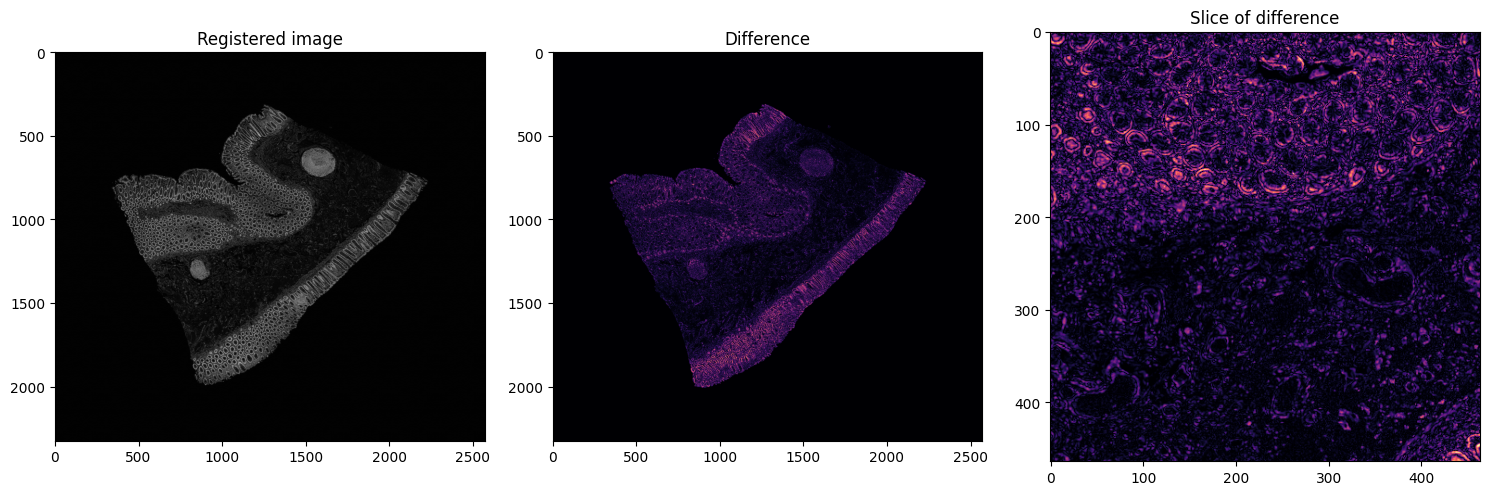

In [23]:
vis = [img_mmi_glob]  # lista SimpleITK.Image
print(type(bior_hem1[0]), type(vis[0]))
print(bior_hem1[0].dtype)

fig, axes = plt.subplots(len(vis), 3, figsize=(15 * len(vis), 10))

for i in range(len(vis)):
    ax = axes if len(axes.shape) == 1 else axes[i]
    
    # Konwersja SimpleITK.Image do ndarray
    vis_np = sitk.GetArrayFromImage(vis[i]).astype(np.uint8)

    print(vis_np.shape)
    print(bior_hem1[0].shape)

    # Oblicz różnicę
    diff = cv2.absdiff(bior_hem1[0], vis_np)

    # Wyświetlanie obrazów
    ax[0].imshow(vis_np, cmap='gray')  # kanał R (lub pierwszy z RGB)
    ax[0].set_title('Registered image')

    ax[1].imshow(diff, cmap='magma')  # różnica
    ax[1].set_title('Difference')

    ax[2].imshow(relative_slice(diff), cmap='magma')
    ax[2].set_title('Slice of difference')

plt.tight_layout()
plt.show()


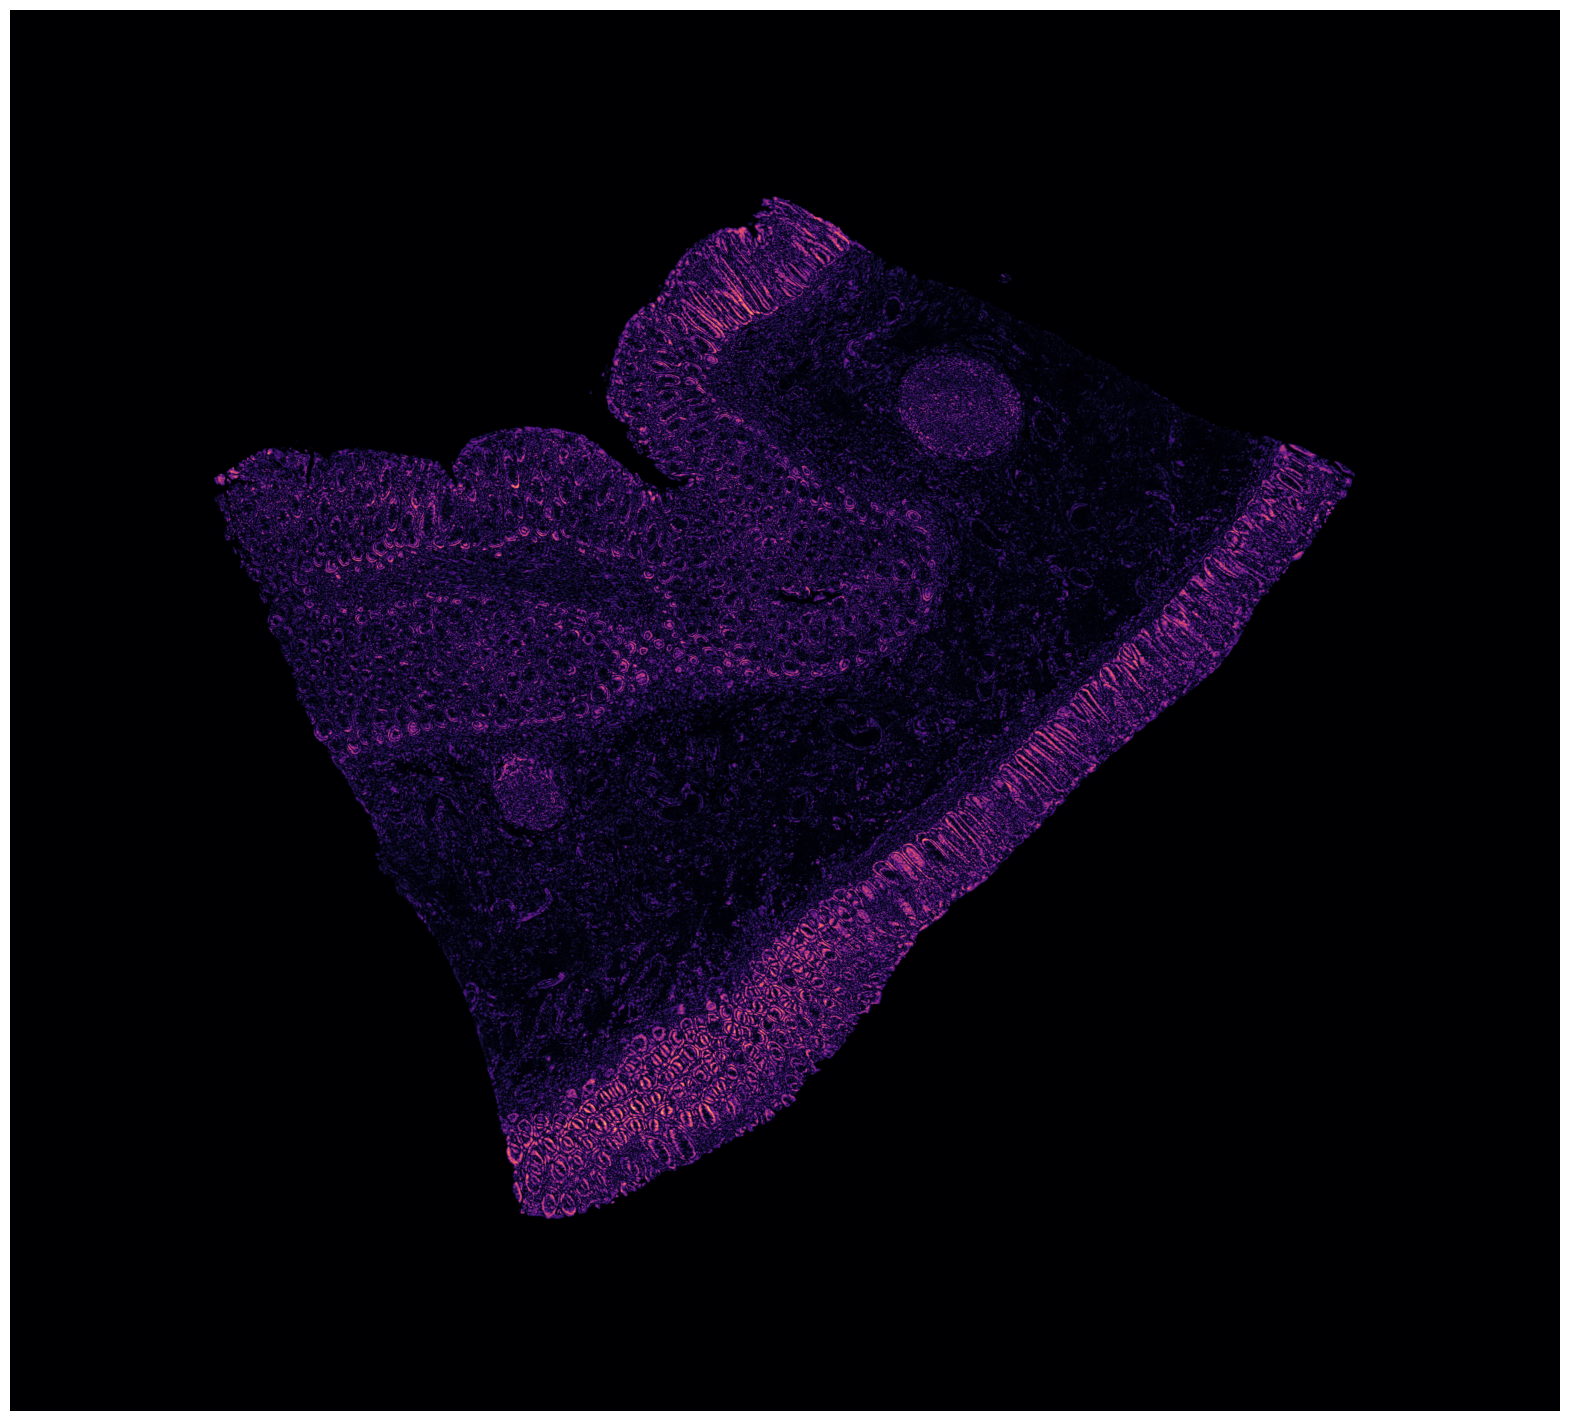

In [24]:
vis_np = sitk.GetArrayFromImage(vis[0]).astype(np.uint8)

diff = cv2.absdiff(bior_hem1[0], vis_np)

plt.figure(figsize=(20,20))
plt.imshow(diff, cmap='magma')
plt.axis('off')
plt.show()

In [ ]:
import torch
import numpy as np
import cv2
import sys

from external import RAFT
from  import InputPadder        # <- to jest poprawne
from torchvision import transforms

# Ładowanie modelu RAFT
def load_raft_model():
    model = torch.nn.DataParallel(RAFT())
    model.load_state_dict(torch.hub.load_state_dict_from_url(
        'https://github.com/princeton-vl/RAFT/releases/download/v1.0/raft-sintel.pth',
        map_location='cpu'
    ))
    model = model.module
    model.eval()
    return model

# Oblicz optyczny flow
def compute_flow(model, image1, image2):
    # Konwersja do tensorów
    transform = transforms.ToTensor()
    image1 = transform(image1).unsqueeze(0)
    image2 = transform(image2).unsqueeze(0)

    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)

    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
    return flow_up[0].permute(1, 2, 0).cpu().numpy()

# Warping obrazu według flow
def warp_image(image, flow):
    h, w = flow.shape[:2]
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + flow[..., 0]).astype(np.float32)
    map_y = (grid_y + flow[..., 1]).astype(np.float32)
    warped = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return warped

# --- Główna funkcja ---
def morph_images(layer_1, layer_2):
    raft_model = load_raft_model()

    # Zakładamy że obrazy są RGB uint8
    img1 = cv2.cvtColor(layer_1, cv2.COLOR_RGB2BGR)
    img2 = cv2.cvtColor(layer_2, cv2.COLOR_RGB2BGR)

    flow_12 = compute_flow(raft_model, img1, img2)
    flow_21 = compute_flow(raft_model, img2, img1)

    # Interpolujemy flow do środka (0.5)
    flow_1_half = flow_12 * 0.5
    flow_2_half = flow_21 * 0.5

    warp1 = warp_image(layer_1, flow_1_half)
    warp2 = warp_image(layer_2, flow_2_half)

    # Uśrednienie (alpha blending)
    layer_morph = ((warp1.astype(np.float32) + warp2.astype(np.float32)) / 2).astype(np.uint8)
    return layer_morph

ImportError: cannot import name 'RAFT' from 'raft' (c:\Users\48500\AppData\Local\Programs\Python\Python313\Lib\site-packages\raft\__init__.py)

In [ ]:
layer_1 = bior_hem1[0].astype(np.float32)
layer_2 = sitk.GetArrayFromImage(img_mmi_glob)

cv2.imwrite("../temp/layer_1.png", layer_1)
cv2.imwrite("../temp/layer_2.png", layer_2)

layer_morph = morph_images(layer_1, layer_2)

plt.imshow(layer_morph, cmap='gray')
plt.axis('off')
plt.show()

fig, axes = plt.subplots(1, 2)
axes[0].imshow(cv2.absdiff(layer_morph, layer_1), cmap='magma')
axes[1].imshow(cv2.absdiff(layer_morph, layer_2), cmap='magma')
plt.show()

NameError: name 'bior_hem1' is not defined